# extrapolate

In [44]:
from chartpeer.loader import load
from chartpeer.analysis import *

# load bitcoin daily data (1440 minutes = 24h interval)
data = load.closedFromFile('XBTUSD_1440.csv')

# get 365 recent days of bitcoin closed prices
fade = 450
yearDataset = data[-365-fade:-fade]

# split the the year in 11 months and one additional "continuation" month
# this helps to compare the prediction to real data
testSet = yearDataset[:335]
continuation = yearDataset[335:365]

## extrapolate.hw

Holt Winters algorithm for seasonal prediction with smoothing parameters $\alpha,\beta,\gamma$.
In the method the parameters are fitted by hand (see example below) and can then used persistently for further predictions.

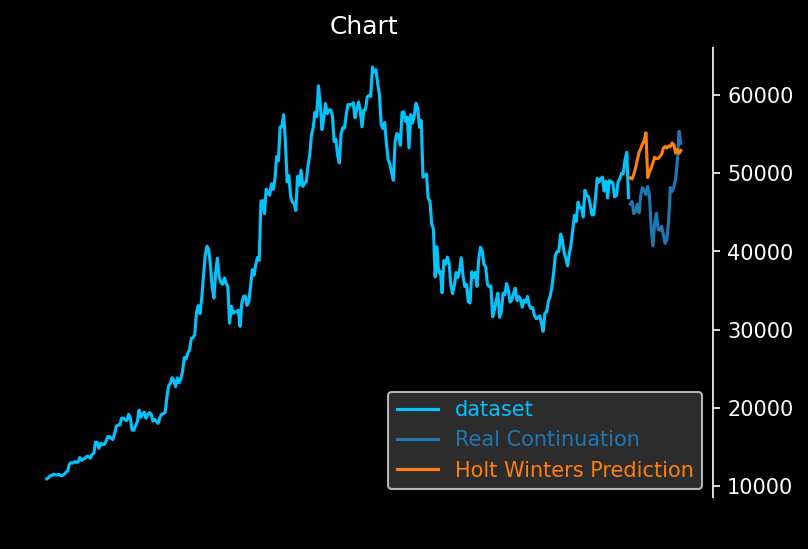

In [45]:


# perform holt winters prediction for 30 days
from chartpeer.extrapolate import hw
prediction = hw(testSet, 30, 0.22, 0.125, 0.125, periodInIntervals=30)

# plot the result for comparison
plot.chart(testSet, predictionSets = {
    'Real Continuation': continuation,
    'Holt Winters Prediction': prediction
})

In the second example the autotuner `hw_fit` is used to fit the parameters using the test set only, and will return an injectable tuple `[alpha, beta, gamma]`

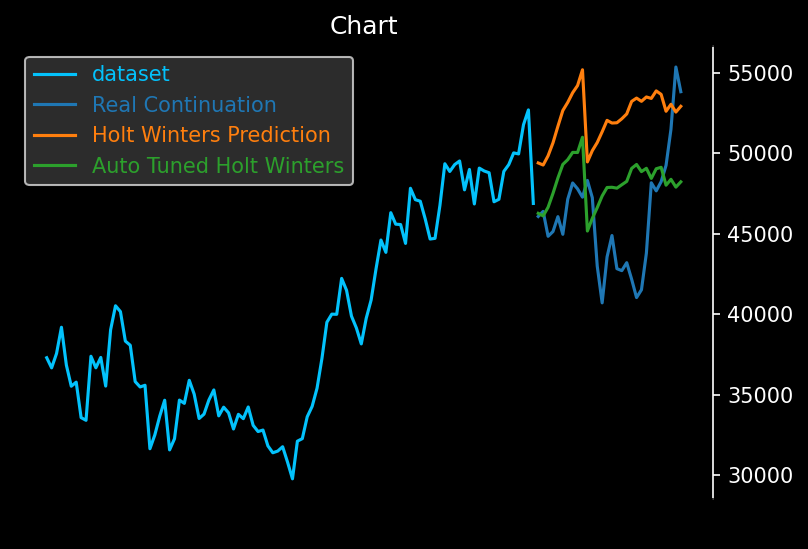

In [46]:
from chartpeer.extrapolate import hw_fit

# fit smoothing parameters by providing demanded extrapolation size and period 
# this can take a couple of seconds.
fit = hw_fit(testSet, 30, periodInIntervals=30, fitRange=[0,1])

# inject fit into new prediction
prediction_auto = hw(testSet, 30, *fit, periodInIntervals=30)

# plot again all results for comparison
plot.chart(testSet[-100:], predictionSets = {
    'Real Continuation': continuation,
    'Holt Winters Prediction': prediction,
    'Auto Tuned Holt Winters': prediction_auto
})

The auto-tuned parameters save time compared to manual fitting and most often lead to sufficient results, as shown in the chart.
In the last example the focus lies on the period dependency. For this compare different periods like 7, 14, 30.

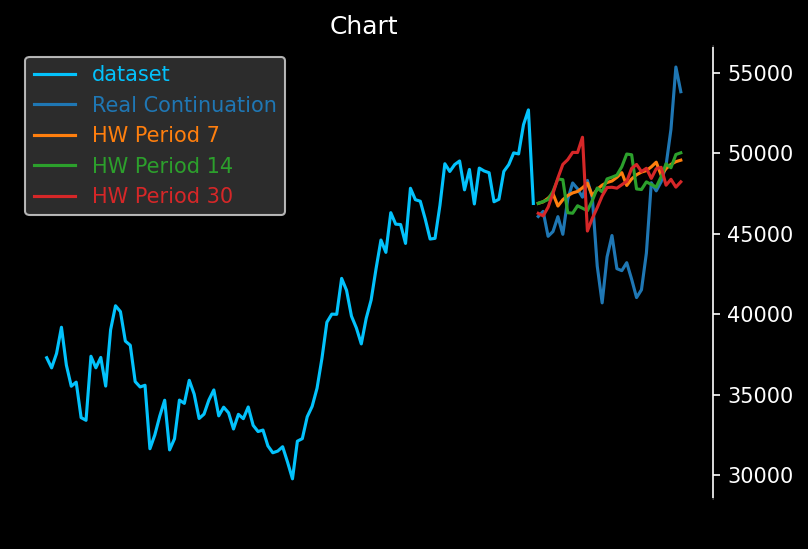

In [47]:

fit_7 = hw_fit(testSet, 30, periodInIntervals=7, fitRange=[0,1])
fit_14 = hw_fit(testSet, 30, periodInIntervals=14, fitRange=[0,1])
fit_30 = fit # known already

# create predictions
prediction_30 = hw(testSet, 30, *fit_30, periodInIntervals=30)
prediction_14 = hw(testSet, 30, *fit_14, periodInIntervals=14)
prediction_7 = hw(testSet, 30, *fit_7, periodInIntervals=7)

# plot again all results for comparison
plot.chart(testSet[-100:], predictionSets = {
    'Real Continuation': continuation,
    'HW Period 7': prediction_7,
    'HW Period 14': prediction_14,
    'HW Period 30': prediction_30,
})

Combining two HW periods with weights often makes sense for a better prediction fit as follows. Here a bias is introduced to shift the output vertically and whose value can be fitted automatically, but it can also be assumed that the bias persists throughout new generations. 

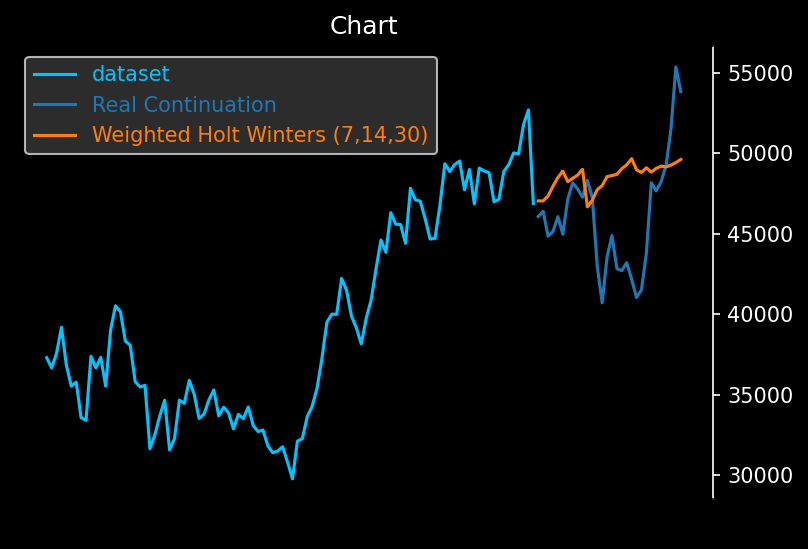

In [48]:
weight_7 = 0.2
weight_14 = 0.4
weight_30 = 0.4
bias = 400

weightedPrediction = weight_7 * prediction_7 + weight_14 * prediction_14 + weight_30 * prediction_30 + bias

# plot the weighted prediction
plot.chart(testSet[-100:], predictionSets = {
    'Real Continuation': continuation,
    'Weighted Holt Winters (7,14,30)': weightedPrediction
})


## extrapolate.gbm

Geometric Brownian motion, a Monte Carlo method for sampling new random values according to a gaussian or intrinsic distribution model of returns obtained from the given dataset. New values are generated with an inversion sampling algorithm, the process has a Markov property.

In [30]:
from chartpeer.extrapolate import gbm

In [31]:
# from tools.extrapolate import gbm

normal = gbm(testSet, 30, 100, sampling='normal')
intrinsic = gbm(testSet, 30, 100, sampling='intrinsic')

# plot the weighted prediction
plot.chart(testSet[-100:], predictionSets = {
    'Real Continuation': continuation,
    'GBM normal generation': normal[0],
    'GBM intrinsic generation': intrinsic[0]
})

AttributeError: module 'numpy.random' has no attribute 'norm'

Every Monte Carlo generation will be random, but sampled from the intrinsic return distribution (either measured intrinsically or modelled with a standard normal). This method is used to map the usecase of an "intrinsic" (as possible) prediction demand based on historic price data purely. So the most pragmatic way is to simulate the prediction period (e.g. all 30 days) with respect to the underlying statistic. The full period can be simulated a large number of times which creates generation arrays. From these arrays we can then ask questions, for instance what the likelihood is that a specific price line is touched by counting those generations which crossed the price and deviding by the total number. This is almost-likely going to estimate the intrinsic probability of that event (weak law of large numbers limit).

In [32]:
generations_array = {}
id = 0
for g in intrinsic:
    generations_array[str(id)] = g
    id += 1

# plot all MC generations at once
plot.chart(testSet[-100:], predictionSets=generations_array, renderLegend=False)

NameError: name 'intrinsic' is not defined

A probability calculation can be performed by selection rules, for instance iterate through every generation and check if a limit is reached. Note that the standard error $\frac{1}{\sqrt{N}}$ factors into the mean and variance measurement, hence for 100 generations the probablity expectation might vary for $10\%$.

In [ ]:
startPrice = testSet[-1]
_return = 0.05 # 2% positive return
count = 0
for g in intrinsic:
    for v in g:
        if v >= (1+_return)*startPrice:
            count += 1
            break

likelihood = count/len(intrinsic)
print(f'Likelihood for {_return*100}% return in 30 days:', likelihood)

In [1]:
def gbmStats (gbm, limitPrice, stopPrice):
    
    w, l = 0, 0
    for g in gbm:
        for i in range(1,len(g)):
            if g[i] >= limitPrice and g[i-1] < limitPrice or g[i] <= limitPrice and g[i-1] > limitPrice:
                w += 1
                break
            elif g[i] >= stopPrice and g[i-1] < stopPrice or g[i] <= stopPrice and g[i-1] > stopPrice:
                l += 1
                break
    return {
        'limit': w/len(gbm),
        'stop': l/len(gbm),
        'std_err': 1/np.sqrt(len(gbm))
    }

In [2]:
# compute the likelihoods of reaching a limit price and stop price, 
# the standard error depends indirectly on the number of generations 
gbmStats(intrinsic, 18000, 15000)

NameError: name 'intrinsic' is not defined

## extrapolate.lstm

A from-scratch long short term memory (LSTM) neural network API, for "out-of-the-box" predictions.This RNN learns sequential patterns right on the spot and gives decent results with only limited amount of data points. Every prediction returns a 1d timeseries array and the loss (mean squared error). If a loss of ~1% or less is reached the predictions can be expected to have fitted the data sufficient enough to determine pattern behaviour, then the prediction can be seen as trust-worthy (within the loss tolerance) but not guaranteed due to off-the-chart events.


- Hyper parameters can be provided via arguments

In [23]:
from chartpeer.extrapolate import lstm

# initialize an LSTM network which predicts 14 days based on last 60 days
#predictor = lstm(sequence_length=60, feature_length=14, epochs=20, batch_size=10)

prediction = predictor.predict(testSet)

Epoch 1/20
27/27 [==============================] - 3s 26ms/step - loss: 0.0553
Epoch 2/20
27/27 [==============================] - 1s 26ms/step - loss: 0.0201
Epoch 3/20
27/27 [==============================] - 1s 26ms/step - loss: 0.0190
Epoch 4/20
27/27 [==============================] - 1s 25ms/step - loss: 0.0182
Epoch 5/20
27/27 [==============================] - 1s 26ms/step - loss: 0.0245
Epoch 6/20
27/27 [==============================] - 1s 25ms/step - loss: 0.0160
Epoch 7/20
27/27 [==============================] - 1s 25ms/step - loss: 0.0156
Epoch 8/20
27/27 [==============================] - 1s 25ms/step - loss: 0.0147
Epoch 9/20
27/27 [==============================] - 1s 25ms/step - loss: 0.0139
Epoch 10/20
27/27 [==============================] - 1s 26ms/step - loss: 0.0136
Epoch 11/20
27/27 [==============================] - 1s 26ms/step - loss: 0.0132
Epoch 12/20
27/27 [==============================] - 1s 26ms/step - loss: 0.0137
Epoch 13/20
27/27 [==================

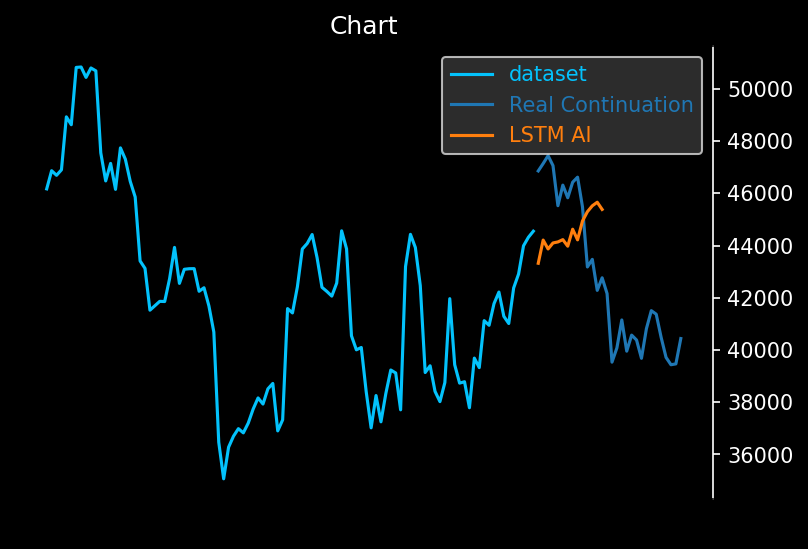

In [24]:
# plot the weighted prediction
plot.chart(testSet[-100:], predictionSets = {
    'Real Continuation': continuation,
    'LSTM AI': prediction['prediction'],
})

# Black Scholes Appendix

The following derivation of geometric brownian motion and black scholes theory is for the sake of understanding and motivated by development and research.

## Assumptions
The price of one instrument is assumed to be non-zero and discretely and equidistantly seperated by constant intervals of time $\Delta t$. This helps in the following definitions as $t \in \mathbb{N}$ acts as a natural discrete index such that the total time is mapped in linear increments $T \coloneqq t \cdot \Delta t$ with $\Delta t \in \mathbb{R}$. Prices will be denoted as $S_{t} \in \mathbb{Q}^+$ and can be related (dynamically) through the discrete evolution of time as $S_{t+1} \leftarrow S_{t}$.



## Dynamic Return Algebra
Before introducing geometric brownian motion and black scholes theory 
In general, timeseries values can be denoted in two ways: absolutely or relatively (successor price relators) - latter method was successfully used in in pure and applied mathematics, such as finance, to model timeseries patterns by using geometric return formalism. Although many models tread "trends" in terms of an expected return as deterministic, constant over time, and almost surely. However, in uncertainty related fields such as hedging positions it can be shown that the proper quantitative risk management allows for more profitable decision making.

A geometric and discrete time step is said to be stationary if it can be expressed recursively 

\begin{align*}
R_t : S_{t} = R_t \cdot S_{t-1}  \Leftrightarrow R_t := S_{t}/S_{t-1} \in \mathbb{Q^+}
\end{align*}

thus the price reading $S$ at some arbitrary time $t$ can be formulated in pure statistical  dependence to it' 
therefore a price at some arbitrary time $t$ can be reconstructed by knowing the starting price at $t_0 := 0$ and all returns

\begin{align*}
S_{t} \leftarrow R_{t} \cdot S_{t-1} \leftarrow R_{t-1} \cdot S_{t-2} ... \leftarrow R_{1} \cdot S_0 \newline
\end{align*}


which results in a well-defined price mapping at any time simply by computing the product of all returns

\begin{align*}
S_{t} = R_t \cdot S_{t-1} = R_t \cdot R_{t-1} \cdot S_{t-2} = R_t \cdot R_{t-1} \cdot R_{t-2} \cdot S_{t-3} = ... \\

= R_t \cdot ... \cdot R_{1} \cdot S_{0} = \prod_{i=0}^{t} R_{i} \cdot S_{0}

\end{align*}

In the following we will define a geometric mean of the return in which we assume that on average $R_i = \left \langle R \right \rangle_g = const.$, the g indicates the geometric mean, across all discrete intervals. Although it needs to be disclaimed that this assumption is an expectation, with the $R_i$ fluctuating around it but when meaned converge to this expectation value, it allows the product to collapse to a single exponential notation 

\begin{align*}
S_{t} = \prod_{i=0}^{t} R_{i} \cdot S_{0} \equiv \left \langle R \right \rangle_g^{t} \cdot S_{0} \\

\left \langle R \right \rangle_g := \sqrt[t]{\prod_{i=0}^{t} R_{i}}

\end{align*}

From the upper equations one can conclude that the price modelling (which neglects fluctuations) has to result in an exponential form. For further algebraic decomposition it is useful to logarithmize the geom. expectation

\begin{align*}
log(\left\langle R \right\rangle_g) = log \left ( \sqrt[t]{\prod_{i=0}^{t} R_{i}} \right )\\ 
= \frac{1}{t} \cdot log \left ( \prod_{i=0}^{t} R_{i} \right )\\

= \frac{\sum_{i=0}^{t} log \left (  R_{i} \right )   }{t} \\

=: \left\langle log \left (  R \right ) \right\rangle_a

\end{align*}

where the index $a$ indicates an arithmetic mean. In conclusion, the logarithmized geometric mean yields just the arithmetic mean of the logarithmic returns.

Substitute this notation in the initial price equation

\begin{align*}
S_{t} = S_{0} \cdot \left \langle R \right \rangle_g^{t} = S_{0} \cdot e^{ \left\langle log \left (  R \right ) \right\rangle_a \cdot t } \equiv  S_{0} \cdot e^{ \,\mu \cdot t } \\

\mu := \left\langle log \left (  R \right ) \right\rangle_a

\end{align*}

in the last step the global parameter $\mu$ was introduced which in literature is often declared as the "drift" i.e. the expectation (arithmetic mean) of logarithmic returns. Hence a constant geometric rate $\left\langle R \right\rangle_g$ (on increment scale) evidently results in an exponential time evolution of the price (on macroscopic- or net scale). We derive at a form where the price depends only on time and is characterized by a single constant scalar - the drift. This parameter fixes the exponential falloff, and acts as the expected return (meaned over an interval unit) and thus needs to be unit-less since we initially defined $t$ without a unit.

We arrive at the expected time-dependent price equation

\begin{align*}
S_{t} =  S_{0} \cdot e^{ \,\mu \cdot t }
\end{align*}

## Mean-Field and Volatility

To focus on the more realistic case we introduce mutually distinct returns $R_t \neq const.$ to arrive at the general price equation again, recall

\begin{align*}
S_{t} = S_{0} \cdot \prod_{i=1}^{t} R_{i}   
\end{align*}

This time the $R_i$ will be estimated in a similar fashion as for the drift, using a mean-field approach. However, we are not focusing on the expected mean solution, which will evidently result in the drift again, but in the fluctuations.  

To get a proper statistical interpretation in terms of an expectation and standard deviation an arithmetic mean is needed, for this purpose the drift definition becomes very handy, and will justify the apriori derivation effort. The mean field ansatz is analogous to the mean derivation except for one extension: every return can be expressed logarithmically to exploit the artithmetic form with constant mean and varying fluctuation

\begin{align*}
log(R_i) = \left\langle log \left (  R \right ) \right\rangle_a + \delta log(R_i) \\
\Leftrightarrow log(R_i) = \mu + \delta \mu_i
\end{align*}

since $R_i \neq R_j \, \forall \, i \neq j$ and $\mu$ is constant by definition, the only left option for a unique return formation are unique fluctuations

\begin{align*}
\delta log(R_i) = log(R_i) - \left\langle log \left (  R \right ) \right\rangle_a \\
\end{align*}

<strong>Geometric brownian motion</strong> assumes randomly generated increments (sampled from a modelled distribution) on every interval. The differences $log(R_i) - \left\langle log \left (  R \right ) \right\rangle_a$ are assumed to be statistically independent and origin from a standard normal distribution which fulfill the definition of a <strong>Wiener process</strong>

\begin{align*}

W := \left \{ W_i: \, W_i-W_{i-1} = \frac{log(R_i) - \left\langle log \left (  R \right ) \right\rangle_a}{\sigma} \sim \mathcal{N}(0,1) \land P(W_i \mid W_j) = P(W_i) \cdot P(W_j) \, \forall \, i,j \right \} 
\end{align*}

the increments $dW_i := W_i-W_{i-1}$ are scaled by a relative problem-specific factor $\sigma$, measured in same dimension as $\mu$. When cummulated they make up the $i$-th value in the sequence i. e. $W_t=dW_1+...+dW_t$

Thus every incremental $R_i$ can be interpreted to move according to the expected incremental drift which is accompanied by a unique fluctuation around the drift expectation. $\sigma$ is called the <strong>volatility</strong> which accounts for the scaling of the random wiener contribution and is associated with a scalar uncertainty merit across the process. An arbitrary logarithmized return can be described as

\begin{align*}
log(R_i) = \underset{\left\langle log \left (  R \right ) \right\rangle_a}{\underbrace{\mu}}  + \underset{\delta log(R_i) }{\underbrace{ \sigma \cdot dW_i }} 
\end{align*}

Note that this extension still respects the apriori derived mean solution, since in the $\sigma = 0$ case we return to the mean solution, this will be consistent in the following.

All $R_{i}$ are stat. indep. which legitimates the product notation 

\begin{align*}
S_{t} = S_{0} \cdot \prod_{i=1}^{t} R_{i} = S_{0} \cdot \prod_{i=1}^{t} e^{log(R_i)} = S_{0} \cdot \prod_{i=1}^{t} e^{ \, \mu + \sigma \cdot dW_i} = S_{0} \cdot e^{\mu t} \prod_{i=1}^{t} e^{ \sigma \cdot dW_i}
\end{align*}

The uncertain wiener volatility contributes as a decoupled (indep.) global factor, a product at first glance, however the $W_i$ were sampled independent of each other and of time

\begin{equation}
\prod_{i=1}^{t} e^{ \sigma \cdot dW_i} = e^{\sigma \cdot dW_1} \cdot ... \cdot e^{\sigma \cdot dW_t} = e^{\sigma \cdot \left\langle dW_i \right\rangle_a \cdot t}  \equiv e^{\sigma \cdot \sqrt{t} \cdot dW \cdot t}
\end{equation}



in essence 

\begin{align*}
\sigma \cdot (dW_1 + ... + dW_t) = \sigma \cdot  \sqrt{t} \cdot dW \cdot t \,\, where \,\, W_i \sim \mathcal{N}(0,1) \land \left\langle dW_i \right\rangle_a \sim \mathcal{N}(0,\frac{1}{\sqrt{t}}) \land \sqrt{t} \cdot dW \sim \mathcal{N}(0,1) \,\, for \,\, t\rightarrow \infty
\end{align*}

where $W$ acts as an arithmetic ("standardized") mean, simply by comparing with the left sum, and for large $t$ is governed by the `central limit theorem` which states that the sum of identically distributed and independently sampled $W_i$ (called iid), $W$ will (almost surely) converge to a normal distribution identically to the $W_i$, just scaled by a factor $\sqrt{t}$. Further concluded, the cumulated value (actual Wiener process value) $W_i$ which by definition can be formulated as an arithmetic expectation as well

\begin{align*}
W_t := dW_1 + ... + dW_t = \frac{dW_1 + ... + dW_t}{t} \cdot t = \left\langle dW_i \right\rangle_a \cdot t = \sigma \cdot \sqrt{t} \cdot dW \cdot t
\end{align*}

can be expressed now by a single increment sample $dW$ from $\mathcal{N}(0,\frac{1}{\sqrt{t}})$. The equality arises from the same origin distribution for both random variables $\left\langle dW_i \right\rangle_a  \sim \sqrt{t} \cdot dW  \sim \mathcal{N}(0,1) $.

After inserting this into the product above we finally arrive at the <strong>mean-field-approximated</strong> geometric brownian price equation

\begin{align*}
S_t = S_0 \cdot e^{\mu t + \sigma \cdot \sqrt{t} \cdot dW \cdot t} = S_0 \cdot e^{\mu t + \sigma \cdot W_t}
\end{align*}

which depends on time, the drift $\mu$ and volatility $\sigma$, as well as the simple integrated Wiener process value $W_t$. To highlight the improvement both versions are denoted for comparison: rather than sampling and integrating $t$ independend samples to obtain $W_t$, $S_t$ can be computed by a single sample obtained from $\mathcal{N}(0,1/\sqrt{t})$. This finding increases the computing efficiency by a factor of $t$ and the estimated equality is being approached almost surely for $t\rightarrow \infty$.

# Itô's Interpretation 

The interpretation in the last section is biased from the actual definition of the geometric brownian motion. This is because the found solution

\begin{align*}
S_t = S_0 \cdot e^{\mu t + \sigma \cdot W_t}
\end{align*}

does not solve the stochastic differential equation

\begin{align*}
dS_t = \mu S_t \cdot dt + \sigma \cdot S_t \cdot dW_i
\end{align*}

where $dt$ was neglected in the derivation before since $t$ was defined to be discrete and $\mu$ was meaned (to compensate the discrete time steps) over the actual interval $\Delta t$.

Instead, the analytical solution is

\begin{align*}
S_t = S_0 \cdot e^{(\mu-\frac{\sigma^2}{2}) \cdot t + \sigma \cdot W_t}
\end{align*}

whose derivation requires Itô calculus. Before proceeding to the derivation and cause of the mean-field bias $\delta S_{MF}$ it will first be quantified to validate the mean-field solution

\begin{align*}
\delta S_{MF} = \frac{S_t [MF] - S_t}{S_t} = \frac{S_0 \cdot e^{\mu t + \sigma \cdot W_t} - S_0 \cdot e^{(\mu-\frac{\sigma^2}{2}) \cdot t + \sigma \cdot W_t}}{S_0 \cdot e^{(\mu-\frac{\sigma^2}{2}) \cdot t + \sigma \cdot W_t}} \\

= \frac{e^{\mu t + \sigma \cdot W_t} -  e^{(\mu-\frac{\sigma^2}{2}) \cdot t + \sigma \cdot W_t}}{e^{(\mu-\frac{\sigma^2}{2}) \cdot t + \sigma \cdot W_t}} \\

= \frac{e^{\mu t} e^{\sigma \cdot W_t}} {e^{\mu t} e^{-\frac{\sigma^2 \cdot t}{2}} e^{ \sigma \cdot W_t}}-1 \\

= \frac{1} {e^{-\frac{\sigma^2 \cdot t}{2}}}-1 \\

= e^{\frac{\sigma^2 \cdot t}{2}} - 1
\end{align*}

We directly find that in the low volatility limit the bias vanishes

\begin{align*}
\lim_{\sigma \rightarrow 0} \delta S_{MF} \rightarrow 0
\end{align*}

from which it can be concluded that the bias actually originates from a wrong volatility derivation which most likely originates in the integration steps of the wiener process. For low volatile timeseries the MF solution can give a proper approximation, however with growing timeseries with $t$ elements the bias scales exponentially, since $\frac{\delta S}{\delta t} \propto e^{\frac{\sigma^2 \cdot t}{2}}$ 